In [233]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

from statsmodels.tsa.arima.model import ARIMAResults, ARIMA
from scipy.stats import burr, burr12, fisk
from pykalman import KalmanFilter

from utils import *
from tqdm import tqdm

In [44]:
cwd = os.getcwd()

full_data = pd.read_csv(os.path.join(cwd, 'data\\full_v3.csv'))
full_data['Price'] = full_data['Price'].apply(np.log)

In [47]:
data = full_data

In [ ]:
data = full_data.drop(columns=['YoY','MoM-1','MoM-2','MoM-3','MoM-4','MoM-5','MoM-6'])

In [48]:
data_2013_1 = data[(data['Year']==2013.0) & (data['Month']==1.0)]

In [6]:
c, d, loc, scale = burr.fit(data_2013_1['Price'])

In [7]:
pct = burr.cdf(data_2013_1['Price'],c,d,loc,scale)
price = burr.ppf(pct,c,d,loc,scale)

In [49]:
pd.options.mode.chained_assignment = None
data_pct = data_2013_1.drop(columns=['Price','Year','Month']).iloc[:0]
test_data = data_pct.copy()
test_data

,PropID,Suburb,Bedrms,Bathrms,Cars,LandSize,BuildingArea,YearBuilt,ICSEA_Primary,ICSEA_Year7,IRSD,IRSAD,IER,IEO,Population


In [50]:
for year in np.linspace(2013.0,2016.0,4):
    for month in np.linspace(1.0,12.0,12):
        temp_data = data[(data['Year']==year) & (data['Month']==month)]
        c, d, loc, scale = burr.fit(temp_data['Price'])
        pct = burr.cdf(temp_data['Price'],c,d,loc,scale)
        temp_data = temp_data.drop(columns=['Price','Year','Month'])
        temp_data['pct'] = pct
        data_pct = pd.concat([data_pct,temp_data],ignore_index=True)

In [52]:
for month in np.linspace(1.0,12.0,12):
    temp_data = data[(data['Year']==2017.0) & (data['Month']==month)]
    c, d, loc, scale = burr.fit(temp_data['Price'])
    pct = burr.cdf(temp_data['Price'],c,d,loc,scale)
    temp_data = temp_data.drop(columns=['Price','Year','Month'])
    temp_data['pct'] = pct
    test_data = pd.concat([test_data,temp_data],ignore_index=True)

In [57]:
p = []
for i in tqdm(range(test_data.shape[0])):
    t = test_data.iloc[i,]
    p.append([t['pct']]+list(data_pct[(data_pct['PropID']==t['PropID'])]['pct']))

100%|██████████| 29200/29200 [09:37<00:00, 50.54it/s]


In [58]:
p

[[0.9438826790039467],
 [0.9871145307901423],
 [0.2307797070275812],
 [0.6356560949567803, 0.35535353578438655],
 [0.2724958862011862],
 [0.4722217211473515],
 [0.5711606903823314],
 [0.652789083581764],
 [0.599960796162872],
 [0.9121039169043544],
 [0.7939328811113046],
 [0.8869334114641946],
 [0.9355443403218185],
 [0.9389363008697793],
 [0.9837892829003417],
 [0.9837892829003417],
 [0.9837892829003417],
 [0.9382773897663009],
 [0.9408572994875533, 0.8308462841779176],
 [0.8094732007120308],
 [0.8403659299484104, 0.5783212269617953],
 [0.6241534864286503],
 [0.23906252225394561, 0.13174911568347308],
 [0.3579646830380025, 0.14734701636244085],
 [0.7108478473412412],
 [0.6485910239035159],
 [0.7108478473412412],
 [0.9837892829003417],
 [0.9793156379196908],
 [0.6746194428260895, 0.40789136751323246],
 [0.6746194428260895, 0.40789136751323246],
 [0.8203728493208948],
 [0.6746194428260895, 0.40789136751323246],
 [0.6746194428260895, 0.40789136751323246],
 [0.5559831321974239],
 [0.61359

In [ ]:
r1 = []
r2 = []
for i in p:
    if len(i) > 1:
        

In [12]:
X_train = data_pct.drop(columns='pct')
y_train = data_pct['pct']
temp = test_data.drop(columns='pct')
y_temp = test_data['pct']
X_dev, X_test, y_dev, y_test = train_test_split(temp, y_temp, test_size=0.5, random_state=31)
X_train.shape, X_dev.shape, X_test.shape

((131069, 13), (14600, 13), (14600, 13))

In [13]:
m = xgb.sklearn.XGBRegressor(n_estimators=150, verbosity=0,
    objective='reg:squarederror', early_stopping_rounds=5, subsample = 0.8, reg_lambda = 2, reg_alpha = 4, max_leaves = 200, max_depth = 10, learning_rate = 0.1)
m.fit(X_train, y_train, eval_set=[(X_dev, y_dev)])

[0]	validation_0-rmse:0.27138
[1]	validation_0-rmse:0.24990
[2]	validation_0-rmse:0.23078
[3]	validation_0-rmse:0.21389
[4]	validation_0-rmse:0.19899
[5]	validation_0-rmse:0.18603
[6]	validation_0-rmse:0.17444
[7]	validation_0-rmse:0.16460
[8]	validation_0-rmse:0.15594
[9]	validation_0-rmse:0.14838
[10]	validation_0-rmse:0.14208
[11]	validation_0-rmse:0.13676
[12]	validation_0-rmse:0.13218
[13]	validation_0-rmse:0.12823
[14]	validation_0-rmse:0.12461
[15]	validation_0-rmse:0.12171
[16]	validation_0-rmse:0.11925
[17]	validation_0-rmse:0.11703
[18]	validation_0-rmse:0.11533
[19]	validation_0-rmse:0.11385
[20]	validation_0-rmse:0.11268
[21]	validation_0-rmse:0.11165
[22]	validation_0-rmse:0.11060
[23]	validation_0-rmse:0.10980
[24]	validation_0-rmse:0.10927
[25]	validation_0-rmse:0.10875
[26]	validation_0-rmse:0.10826
[27]	validation_0-rmse:0.10799
[28]	validation_0-rmse:0.10757
[29]	validation_0-rmse:0.10720
[30]	validation_0-rmse:0.10688
[31]	validation_0-rmse:0.10658
[32]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=5, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=200, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=150, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=4,
             reg_lambda=2, ...)

In [14]:
temp_test = data[(data['Year']==2017.0) & (data['Month']==1.0)].drop(columns=['Price','Year','Month'])
y = data[(data['Year']==2017.0) & (data['Month']==1.0)]['Price']
y

314       14.115615
542       14.639686
1006      12.994530
1027      13.410545
1077      13.038982
            ...    
160203    13.249877
160223    12.700769
160234    13.017003
160259    13.321214
160265    13.321214
Name: Price, Length: 1344, dtype: float64

In [15]:
pred = m.predict(temp_test)
pred

array([0.7877179 , 0.9304172 , 0.11067282, ..., 0.2349762 , 0.47425205,
       0.46808845], dtype=float32)

In [16]:
temp_data = data[(data['Year']==2016.0) & (data['Month']==12.0)]
c, d, loc, scale = burr.fit(temp_data['Price'])
y_pred = burr.ppf(pred,c,d,loc,scale)
pct_error(y, y_pred, log=True).abs().mean()

0.846427180682846

In [17]:
result_burr = []
for month in np.linspace(2.0,12.0,11):
    temp_test = data[(data['Year']==2017.0) & (data['Month']==month)].drop(columns=['Price','Year','Month'])
    y = data[(data['Year']==2017.0) & (data['Month']==month)]['Price']
    pred = m.predict(temp_test)
    temp_data = data[(data['Year']==2017.0) & (data['Month']==month-1)]
    c, d, loc, scale = burr.fit(temp_data['Price'])
    print(y.shape,c,d,loc,scale)
    y_pred = burr.ppf(pred,c,d,loc,scale)
    result_burr.append(pct_error(y, y_pred, log=True).abs().mean())

(2721,) 41.612887368441925 4.383120774044977 -0.17507374322671307 12.880678451199248
(3648,) 31.992667792358496 8.73758132805405 -0.17259713724695253 12.591651945910584
(2908,) 30.328672079264663 277.08622064465993 -0.9504625771605812 11.865324085553915
(3270,) 33.24637885253977 6.22579202528503 -0.18866845145629482 12.820620637713183
(2731,) 29.800613642896103 22.09626566750938 -0.2335777261189363 12.249879187755237
(2839,) 32.262423512707585 322.81835474508705 -1.166028000044192 12.129879475548066
(2862,) 36.81844317825624 28.843555226820023 -0.26341912040034465 12.372125275121398
(2731,) 36.63726700910189 363.23598568412444 -1.3753237407590606 12.524434430289498
(2711,) 36.784382058607676 5.275558642409732 -0.19984588877375642 13.03329558765886
(992,) 35.499604305559544 9.83829723743817 -0.20370528786375974 12.781000223186586
(443,) 37.477577791377634 6.950401613667808 -0.22873756124852526 12.933265549502234


In [18]:
result_burr

[2.0749066833971224,
 1.092131216778603,
 0.8959992059525751,
 1.077134946075003,
 0.9501537802203981,
 0.879107936791764,
 1.406008102521214,
 1.1785530038977312,
 1.0571690307922423,
 0.9941629745447543,
 1.0643229777212047]

In [24]:
result_fisk = []
for month in np.linspace(2.0,12.0,11):
    temp_test = data[(data['Year']==2017.0) & (data['Month']==month)].drop(columns=['Price','Year','Month'])
    y = data[(data['Year']==2017.0) & (data['Month']==month)]['Price']
    pred = m.predict(temp_test)
    temp_data = data[(data['Year']==2017.0) & (data['Month']==month-1)]
    c, loc, scale = fisk.fit(temp_data['Price'])
    print(y.shape,c,loc,scale)
    y_pred = fisk.ppf(pred,c,loc,scale)
    result_fisk.append(pct_error(y, y_pred, log=False).abs().mean())

(2721,) 6.204911881746805 11.771233243091068 1.4850151510393976
(3648,) 43.72998605589564 -0.28174610703148995 13.76143690366326
(2908,) 4.152755439478833 12.148738222533328 1.355065345410136
(3270,) 5.855847637293786 11.725388225208636 1.7634239872397766
(2731,) 5.0181835951397735 11.90570168056517 1.6183669569706074
(2839,) 4.225471501441621 12.195203942706165 1.3143561452695467
(2862,) 4.414531478489268 12.290828750230546 1.1253259707374361
(2731,) 3.937305782938727 12.372920185732742 1.0983386986669053
(2711,) 6.9519518032275105 11.624573125026732 1.929112066923354
(992,) 4.888576207750144 12.20414537187455 1.3482831474802026
(443,) 5.390703553496936 12.075633902049058 1.4253214139214898


In [25]:
result_fisk

[24.148511419346516,
 15.485921221509686,
 12.16800056732464,
 13.743697868268082,
 12.591053227142424,
 11.383077497385981,
 17.011665915322713,
 15.24064074398549,
 13.547902404189703,
 15.240271672337412,
 13.578062216454628]

In [21]:
np.array(result_burr)-np.array(result_fisk)

array([-0.06028122, -0.1771763 , -0.01331412, -0.0079249 , -0.01136251,
        0.00539215, -0.01252107, -0.02032415, -0.02503433, -0.00476708,
       -0.03738593])

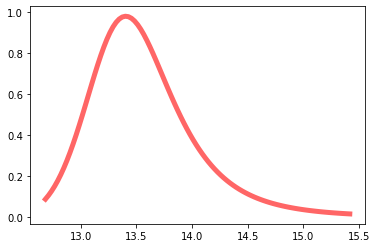

In [22]:
x = np.linspace(fisk.ppf(0.01, c, loc, scale),
                fisk.ppf(0.99, c, loc, scale), 100)
fig, ax = plt.subplots(1, 1)
ax.plot(x, fisk.pdf(x, c, loc, scale),
       'r-', lw=5, alpha=0.6, label='burr pdf')

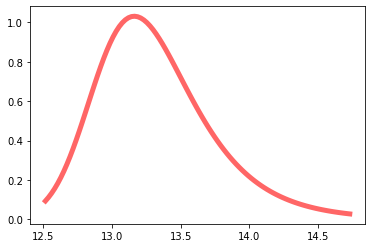

In [23]:
c, d, loc, scale = (41.612887368441925, 4.383120774044977, -0.17507374322671307, 12.880678451199248)
x = np.linspace(burr.ppf(0.01, c, d, loc, scale),
                burr.ppf(0.99, c, d, loc, scale), 100)
fig, ax = plt.subplots(1, 1)
ax.plot(x, burr.pdf(x, c, d, loc, scale),
       'r-', lw=5, alpha=0.6, label='burr pdf')

# Fine Tune PyTorch

In [235]:
from torch import nn
from torch.utils.data import DataLoader
from __future__ import print_function
from __future__ import division
import torch.optim as optim
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
from sklearn.preprocessing import StandardScaler
import os
import torch
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# If there's a GPU available...
# if torch.backends.mps.is_available():
#     device = torch.device("mps")
#     print('We will use the M1 chip acceleration.')
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

PyTorch Version:  1.11.0
Torchvision Version:  0.12.0
There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1080


## Data Loader

In [236]:
class MelbourneDataset(torch.utils.data.Dataset):
    '''
    Prepare the Boston dataset for regression
    '''

    def __init__(self, X, y, scale_data=False):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
        # Apply scaling if necessary
            if scale_data:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

## Define the model

In [251]:
data.shape

(160269, 572)

In [252]:
class MLP(nn.Module):
    '''
    Multilayer Perceptron for regression.
    '''
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(569, 64), # num of input features
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 1)
        )


    def forward(self, x):
        '''
        Forward pass
        '''
        return self.layers(x)

## Prepare the dataset

In [237]:
cwd = os.getcwd()

full_data = pd.read_csv(os.path.join(cwd, 'data/full_v3.csv'))
full_data['Price'] = full_data['Price'].apply(np.log)

In [238]:
data = full_data.drop(columns=['PropID','ICSEA_Primary','ICSEA_Year7','IRSD','IRSAD','IER','IEO','Population'])
pd.options.mode.chained_assignment = None
data_pct = data.drop(columns=['Year','Month']).iloc[:0]
test_data = data_pct.copy()
test_data

,Suburb,Bedrms,Bathrms,Cars,LandSize,BuildingArea,YearBuilt,Price


In [239]:
data_pct
for year in np.linspace(2013.0,2017.0,5):
    for month in np.linspace(1.0,12.0,12):
        temp_data = data[(data['Year']==year) & (data['Month']==month)]
        # c, loc, scale = fisk.fit(temp_data['Price'], loc = 0, scale = 1)
        # pct = burr.cdf(temp_data['Price'],c,loc,scale)
        # temp_data = temp_data.drop(columns=['Year','Month'])
        temp_data['mean'] = sum(temp_data['Price'])/len(temp_data['Price'])
        temp_data['var'] = np.var(temp_data['Price'])
        data_pct = pd.concat([data_pct,temp_data],ignore_index=True)
data_pct

,Suburb,Bedrms,Bathrms,Cars,LandSize,BuildingArea,YearBuilt,Price,Month,Year,mean,var
0,Albert Park,2.0,1.0,0.0,82.0,71.0,1910.0,13.592367,1.0,2013.0,13.021452,0.227561
1,Albert Park,2.0,1.0,0.0,82.0,71.0,1910.0,13.592367,1.0,2013.0,13.021452,0.227561
2,Alphington,3.0,2.0,0.0,691.0,176.0,1930.0,13.883169,1.0,2013.0,13.021452,0.227561
3,Altona Meadows,4.0,2.0,2.0,464.0,150.0,2006.0,12.923912,1.0,2013.0,13.021452,0.227561
4,Altona Meadows,4.0,2.0,1.0,464.0,184.0,2000.0,13.049793,1.0,2013.0,13.021452,0.227561
...,...,...,...,...,...,...,...,...,...,...,...,...
160264,Wyndham Vale,4.0,2.0,2.0,448.0,171.0,2012.0,13.180632,12.0,2017.0,13.543673,0.211018
160265,Yarra Junction,3.0,2.0,4.0,1258.0,191.0,2001.0,13.422468,12.0,2017.0,13.543673,0.211018
160266,Yarra Junction,3.0,2.0,2.0,602.0,139.0,2010.0,13.223113,12.0,2017.0,13.543673,0.211018
160267,Yarra Junction,3.0,2.0,2.0,100.0,136.0,1985.0,13.304685,12.0,2017.0,13.543673,0.211018


In [240]:
from sklearn.preprocessing import OneHotEncoder
data_pct[['LandSize', 'BuildingArea']] = StandardScaler().fit_transform(data_pct[['LandSize', 'BuildingArea']])
enc = OneHotEncoder(handle_unknown='ignore')
enc_year = OneHotEncoder(handle_unknown='ignore')
sub = enc.fit_transform(data_pct.iloc[:,0:1]).toarray()
year_built = enc_year.fit_transform(data_pct.iloc[:,6:7]).toarray()
other = data_pct.iloc[:,1:6].to_numpy()
other2 = data_pct.iloc[:,7:].to_numpy()
data = np.concatenate((sub, other, year_built, other2), axis=1)
data

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        2.01300000e+03, 1.30214519e+01, 2.27561397e-01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        2.01300000e+03, 1.30214519e+01, 2.27561397e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.01300000e+03, 1.30214519e+01, 2.27561397e-01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.01700000e+03, 1.35436733e+01, 2.11017594e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.01700000e+03, 1.35436733e+01, 2.11017594e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.01700000e+03, 1.35436733e+01, 2.11017594e-01]])

In [241]:
import math
from torch import default_generator, randperm
from torch._utils import _accumulate
from torch.utils.data.dataset import Subset

def random_split(dataset, lengths,
                 generator=default_generator):
    r"""
    Randomly split a dataset into non-overlapping new datasets of given lengths.

    If a list of fractions that sum up to 1 is given,
    the lengths will be computed automatically as
    floor(frac * len(dataset)) for each fraction provided.

    After computing the lengths, if there are any remainders, 1 count will be
    distributed in round-robin fashion to the lengths
    until there are no remainders left.

    Optionally fix the generator for reproducible results, e.g.:

    >>> random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))
    >>> random_split(range(30), [0.3, 0.3, 0.4], generator=torch.Generator(
    ...   ).manual_seed(42))

    Args:
        dataset (Dataset): Dataset to be split
        lengths (sequence): lengths or fractions of splits to be produced
        generator (Generator): Generator used for the random permutation.
    """
    if math.isclose(sum(lengths), 1) and sum(lengths) <= 1:
        subset_lengths: List[int] = []
        for i, frac in enumerate(lengths):
            if frac < 0 or frac > 1:
                raise ValueError(f"Fraction at index {i} is not between 0 and 1")
            n_items_in_split = int(
                math.floor(len(dataset) * frac)  # type: ignore[arg-type]
            )
            subset_lengths.append(n_items_in_split)
        remainder = len(dataset) - sum(subset_lengths)  # type: ignore[arg-type]
        # add 1 to all the lengths in round-robin fashion until the remainder is 0
        for i in range(remainder):
            idx_to_add_at = i % len(subset_lengths)
            subset_lengths[idx_to_add_at] += 1
        lengths = subset_lengths
        for i, length in enumerate(lengths):
            if length == 0:
                warnings.warn(f"Length of split at index {i} is 0. "
                              f"This might result in an empty dataset.")

    # Cannot verify that dataset is Sized
    if sum(lengths) != len(dataset):    # type: ignore[arg-type]
        raise ValueError("Sum of input lengths does not equal the length of the input dataset!")

    indices = randperm(sum(lengths), generator=generator).tolist()  # type: ignore[call-overload]
    return [Subset(dataset, indices[offset - length : offset]) for offset, length in zip(_accumulate(lengths), lengths)]

In [242]:
if __name__ == '__main__':
      
    # Set fixed random number seed
    torch.manual_seed(42)
    
    # Load Boston dataset
    y = data[:,-3:-2]
    X = np.delete(data, -3, axis=1)
    dataset = MelbourneDataset(X, y)
    batch_size = 64
    train_dataset, test_dataset = random_split(dataset, [0.8,0.2])
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Initializing the model, loss function and optimizer

In [266]:
# Initialize the MLP
model = MLP().to(device)

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

## Training loop

In [246]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X.float())
        loss = loss_fn(pred, y.float())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

## Testing loop

In [257]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, mape = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            mape += (abs(torch.exp(pred)-torch.exp(y))/torch.exp(y)).type(torch.float32).sum().item()
    test_loss /= num_batches
    mape /= size
    print(f"Test Error: \n MAPE: {(100*mape):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return mape*100

In [248]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_function, optimizer)
    test(test_dataloader, model, nn.L1Loss())
print("Done!")

Epoch 1
-------------------------------
loss: 4060737.000000  [    0/128216]
loss: 4058840.000000  [ 6400/128216]
loss: 4051586.500000  [12800/128216]
loss: 4037253.250000  [19200/128216]
loss: 4013466.000000  [25600/128216]
loss: 3974049.000000  [32000/128216]
loss: 3922168.500000  [38400/128216]
loss: 3855577.500000  [44800/128216]
loss: 3767214.000000  [51200/128216]
loss: 3658544.750000  [57600/128216]
loss: 3519419.500000  [64000/128216]
loss: 3365987.250000  [70400/128216]
loss: 3222230.750000  [76800/128216]
loss: 3027585.000000  [83200/128216]
loss: 2832870.250000  [89600/128216]
loss: 2600890.500000  [96000/128216]
loss: 2346564.000000  [102400/128216]
loss: 2099812.000000  [108800/128216]
loss: 1896851.000000  [115200/128216]
loss: 1655580.000000  [121600/128216]
loss: 1396369.875000  [128000/128216]
Test Error: 
 MAPE: nan%, Avg loss: 1176.153088 

Epoch 2
-------------------------------
loss: 1402970.125000  [    0/128216]
loss: 1150477.750000  [ 6400/128216]
loss: 1001226.

In [37]:
data

,0,1,2,3,4,5,6,7,8,9,...,562,563,564,565,566,567,568,569,570,571
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.592367,1.0,2013.0,13.021452,0.227561
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.592367,1.0,2013.0,13.021452,0.227561
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.883169,1.0,2013.0,13.021452,0.227561
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,12.923912,1.0,2013.0,13.021452,0.227561
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.049793,1.0,2013.0,13.021452,0.227561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.180632,12.0,2017.0,13.543673,0.211018
160265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.422468,12.0,2017.0,13.543673,0.211018
160266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.223113,12.0,2017.0,13.543673,0.211018
160267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.304685,12.0,2017.0,13.543673,0.211018


In [40]:
temp_data

,0,1,2,3,4,5,6,7,8,9,...,560,561,562,563,564,565,566,567,570,571
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.592367,13.021452,0.227561
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.592367,13.021452,0.227561
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.883169,13.021452,0.227561
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.923912,13.021452,0.227561
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.049793,13.021452,0.227561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.449019,13.021452,0.227561
1392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.429216,13.021452,0.227561
1393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.611538,13.021452,0.227561
1394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.468437,13.021452,0.227561


In [262]:
data = pd.DataFrame(data)
temp_data = data[(data[569]==2013.0) & (data[568]==1.0)]
temp_data = temp_data.drop(columns=[568,569])
temp_data = temp_data.to_numpy()
y = temp_data[:,-3:-2]
X = np.delete(temp_data, -3, axis=1)
dataset = MelbourneDataset(X, y)
batch_size = 64
train_dataset, test_dataset = random_split(dataset, [0.8,0.2])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
epochs = 200
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_function, optimizer)
    test(test_dataloader, model, loss_function)
print("Done!")

Epoch 1
-------------------------------
loss: 173.590302  [    0/ 1117]
Test Error: 
 MAPE: 100.0%, Avg loss: 169.050245 

Epoch 2
-------------------------------
loss: 168.017349  [    0/ 1117]
Test Error: 
 MAPE: 100.0%, Avg loss: 167.548745 

Epoch 3
-------------------------------
loss: 170.084488  [    0/ 1117]
Test Error: 
 MAPE: 100.0%, Avg loss: 166.130138 

Epoch 4
-------------------------------
loss: 165.438690  [    0/ 1117]
Test Error: 
 MAPE: 100.0%, Avg loss: 164.890934 

Epoch 5
-------------------------------
loss: 167.778473  [    0/ 1117]
Test Error: 
 MAPE: 100.0%, Avg loss: 163.018411 

Epoch 6
-------------------------------
loss: 163.366028  [    0/ 1117]
Test Error: 
 MAPE: 100.0%, Avg loss: 160.797730 

Epoch 7
-------------------------------
loss: 159.647491  [    0/ 1117]
Test Error: 
 MAPE: 100.0%, Avg loss: 157.659304 

Epoch 8
-------------------------------
loss: 157.821411  [    0/ 1117]
Test Error: 
 MAPE: 100.0%, Avg loss: 155.054404 

Epoch 9
--------

In [263]:
old_X = X
old_y = y
old_dataset = dataset
result = []
for year in np.linspace(2013.0,2017.0,5):
    for month in np.linspace(1.0,12.0,12):
        temp_data = data[(data[569]==year) & (data[568]==month)]
        temp_data = temp_data.drop(columns=[568,569])
        temp_data = temp_data.to_numpy()
        y = temp_data[:,-3:-2]
        X = np.delete(temp_data, -3, axis=1)
        dataset = MelbourneDataset(X, y)
        batch_size = 64
        train_dataloader = torch.utils.data.DataLoader(old_dataset, batch_size=batch_size, shuffle=True)
        test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        epochs = 100
        best_mape = 100
        for t in range(epochs):
            print(f"{year} {month} Epoch {t+1}\n-------------------------------")
            train(train_dataloader, model, loss_function, optimizer)
            mape = test(test_dataloader, model, loss_function)
            if mape < best_mape:
                best_mape = mape
        result.append(best_mape)
        old_dataset = dataset
        print("Done!")

Epoch 1
-------------------------------
loss: 0.170905  [    0/ 1396]
Test Error: 
 MAPE: 32.3%, Avg loss: 0.157177 

Epoch 2
-------------------------------
loss: 0.214442  [    0/ 1396]
Test Error: 
 MAPE: 31.8%, Avg loss: 0.153303 

Epoch 3
-------------------------------
loss: 0.122165  [    0/ 1396]
Test Error: 
 MAPE: 31.5%, Avg loss: 0.150066 

Epoch 4
-------------------------------
loss: 0.161350  [    0/ 1396]
Test Error: 
 MAPE: 30.7%, Avg loss: 0.145636 

Epoch 5
-------------------------------
loss: 0.164945  [    0/ 1396]
Test Error: 
 MAPE: 30.4%, Avg loss: 0.142040 

Epoch 6
-------------------------------
loss: 0.241239  [    0/ 1396]
Test Error: 
 MAPE: 30.2%, Avg loss: 0.140106 

Epoch 7
-------------------------------
loss: 0.104781  [    0/ 1396]
Test Error: 
 MAPE: 29.2%, Avg loss: 0.136140 

Epoch 8
-------------------------------
loss: 0.156349  [    0/ 1396]
Test Error: 
 MAPE: 29.3%, Avg loss: 0.133183 

Epoch 9
-------------------------------
loss: 0.097039  

In [272]:
result

[14.447127918800856,
 23.97671513435291,
 22.437285642465408,
 16.769259042788057,
 17.36550998217062,
 100,
 14.738613339839077,
 20.718629398338507,
 15.050047210611387,
 15.678287015742615,
 15.020629946177632,
 14.240133179177484,
 21.19003206329989,
 21.70498162927762,
 19.952286011140913,
 15.540719041030487,
 15.979182500666594,
 15.821806340533486,
 15.123605373330529,
 21.052027990512403,
 15.013973718063166,
 14.85737913486843,
 13.572258861844025,
 14.418773086228853,
 22.202751935661517,
 29.666087475420166,
 16.503930876526653,
 17.504422423146785,
 22.394819210763565,
 14.608026424288912,
 17.84653155916216,
 22.97034758441853,
 13.255680094795133,
 14.81920360459894,
 14.646060360926333,
 13.816055919711918,
 20.50271391398647,
 27.971931264872907,
 16.08159626333657,
 13.741557886603811,
 13.624127091506608,
 13.599861332686084,
 14.196586900657707,
 15.356926001166343,
 14.230573555258205,
 12.635307625205256,
 12.660415388833638,
 13.79992024245619,
 23.55098703077861

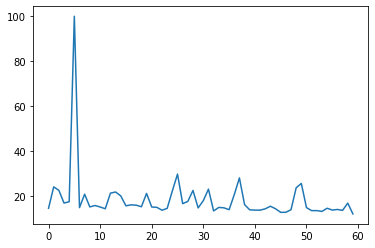

In [265]:
plt.plot(result)

In [267]:
data = pd.DataFrame(data)
temp_data = data[(data[569]<2017.0)]
temp_data = temp_data.drop(columns=[568,569])
temp_data = temp_data.to_numpy()
y = temp_data[:,-3:-2]
X = np.delete(temp_data, -3, axis=1)
dataset = MelbourneDataset(X, y)
batch_size = 64
train_dataset, test_dataset = random_split(dataset, [0.8,0.2])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
epochs = 200
best_mape = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_function, optimizer)
    mape = test(test_dataloader, model, loss_function)
    if mape < best_mape:
        best_mape = mape
        best_model = copy.deepcopy(model.state_dict())
print("Done!")
model.load_state_dict(best_model)

Epoch 1
-------------------------------
loss: 184.231735  [    0/104856]
loss: 175.457962  [ 6400/104856]
loss: 153.410736  [12800/104856]
loss: 114.303009  [19200/104856]
loss: 66.209671  [25600/104856]
loss: 27.070568  [32000/104856]
loss: 6.279114  [38400/104856]
loss: 2.235670  [44800/104856]
loss: 1.512611  [51200/104856]
loss: 1.594393  [57600/104856]
loss: 1.240862  [64000/104856]
loss: 1.284875  [70400/104856]
loss: 1.192851  [76800/104856]
loss: 1.006442  [83200/104856]
loss: 0.899469  [89600/104856]
loss: 0.577587  [96000/104856]
loss: 0.556629  [102400/104856]
Test Error: 
 MAPE: 60.6%, Avg loss: 0.496868 

Epoch 2
-------------------------------
loss: 0.580034  [    0/104856]
loss: 0.422175  [ 6400/104856]
loss: 0.400412  [12800/104856]
loss: 0.398541  [19200/104856]
loss: 0.346973  [25600/104856]
loss: 0.214302  [32000/104856]
loss: 0.185734  [38400/104856]
loss: 0.192397  [44800/104856]
loss: 0.195878  [51200/104856]
loss: 0.190904  [57600/104856]
loss: 0.141552  [64000/1

<All keys matched successfully>

In [269]:
old_dataset = dataset
result2 = []
for month in np.linspace(1.0,12.0,12):
    temp_data = data[(data[569]==2017.0) & (data[568]==month)]
    temp_data = temp_data.drop(columns=[568,569])
    temp_data = temp_data.to_numpy()
    y = temp_data[:,-3:-2]
    X = np.delete(temp_data, -3, axis=1)
    dataset = MelbourneDataset(X, y)
    batch_size = 64
    train_dataset, test_dataset = random_split(dataset, [0.8,0.2])
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    epochs = 200
    best_mape = 100
    result2.append(test(dataloader, model, loss_function))
    for t in range(epochs):
        print(f"{year} {month} Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_function, optimizer)
        mape = test(test_dataloader, model, loss_function)
        if mape < best_mape:
            best_mape = mape
            best_model = copy.deepcopy(model.state_dict())
    model.load_state_dict(best_model)
    print("Done!")

Test Error: 
 MAPE: 18.3%, Avg loss: 0.066231 

2017.0 1.0 Epoch 1
-------------------------------
loss: 0.075196  [    0/ 1076]
Test Error: 
 MAPE: 13.4%, Avg loss: 0.038841 

2017.0 1.0 Epoch 2
-------------------------------
loss: 0.034170  [    0/ 1076]
Test Error: 
 MAPE: 13.7%, Avg loss: 0.037889 

2017.0 1.0 Epoch 3
-------------------------------
loss: 0.025816  [    0/ 1076]
Test Error: 
 MAPE: 13.7%, Avg loss: 0.039395 

2017.0 1.0 Epoch 4
-------------------------------
loss: 0.020712  [    0/ 1076]
Test Error: 
 MAPE: 13.0%, Avg loss: 0.035847 

2017.0 1.0 Epoch 5
-------------------------------
loss: 0.043857  [    0/ 1076]
Test Error: 
 MAPE: 12.9%, Avg loss: 0.040108 

2017.0 1.0 Epoch 6
-------------------------------
loss: 0.021251  [    0/ 1076]
Test Error: 
 MAPE: 13.3%, Avg loss: 0.034930 

2017.0 1.0 Epoch 7
-------------------------------
loss: 0.035135  [    0/ 1076]
Test Error: 
 MAPE: 13.0%, Avg loss: 0.036105 

2017.0 1.0 Epoch 8
------------------------------

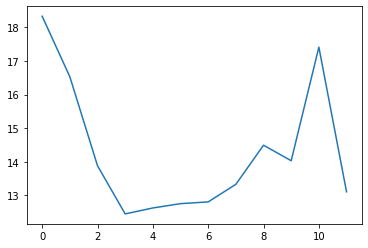

In [271]:
plt.plot(result2)

In [270]:
result2

[18.330812809013185,
 16.52888289622987,
 13.879535399508057,
 12.444676493680133,
 12.622051016635485,
 12.750190118868593,
 12.802466182231736,
 13.325780609285474,
 14.490712688589916,
 14.02835040372133,
 17.410627247825747,
 13.102957572678681]

In [273]:
np.mean(result2)

14.309753619855684